<a href="https://colab.research.google.com/github/jbkalmbach/pzflow-paper-2021/blob/main/photo-z/pzflowRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pzflow Photo-Z
This notebook shows how we built the normalizing flow with `pzflow` to learn the joint probability distribution of galaxy magnitudes and redshifts used for the plots in the paper.

## Imports

**Note**: Run cells in this section every time starting in colab.

In [2]:
!pip install tables_io
!pip install pzflow
!pip install corner

In [1]:
import jax
print(f"jax version is {jax.__version__}")
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
print(f"pzflow version is {pzflow.__version__}")
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow import FlowEnsemble

import os
import pandas as pd

jax version is 0.2.21
pzflow version is 2.0.3


## Load data

**Note**: Run cells in this section every time starting in colab.

The photometric catalog we use in this section is the created using the  notebook CMNN_cat_creation.ipynb in this repository. That notebook creates training and test catalogs using the same dataset used for experiments in the Color Matched Nearest Neighbor (CMNN) papers (Code Repository: https://github.com/dirac-institute/CMNN_Photoz_Estimator, Papers: Graham et al. 2018, AJ, 155, 1 & Graham et al. 2020, AJ, 159, 258).

In [3]:
!wget -O train.cat https://epyc.astro.washington.edu/~brycek/train.cat

--2021-10-28 00:02:44--  https://epyc.astro.washington.edu/~brycek/train.cat
Resolving epyc.astro.washington.edu (epyc.astro.washington.edu)... 140.142.4.22
Connecting to epyc.astro.washington.edu (epyc.astro.washington.edu)|140.142.4.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61000000 (58M)
Saving to: ‘train.cat’

train.cat           100%[===================>]  58.17M  38.6MB/s    in 1.5s    

2021-10-28 00:02:46 (38.6 MB/s) - ‘train.cat’ saved [61000000/61000000]



In [4]:
!wget -O test.cat https://epyc.astro.washington.edu/~brycek/test.cat

--2021-10-28 00:02:46--  https://epyc.astro.washington.edu/~brycek/test.cat
Resolving epyc.astro.washington.edu (epyc.astro.washington.edu)... 140.142.4.22
Connecting to epyc.astro.washington.edu (epyc.astro.washington.edu)|140.142.4.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12200000 (12M)
Saving to: ‘test.cat’

test.cat            100%[===================>]  11.63M  23.0MB/s    in 0.5s    

2021-10-28 00:02:47 (23.0 MB/s) - ‘test.cat’ saved [12200000/12200000]



In [5]:
trainingset = pd.read_csv('train.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [6]:
trainingset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.900582,25.448562,0.124823,25.635542,0.042729,25.454899,0.033699,24.888279,0.036172,24.562720,0.050165,24.472106,0.150306
1,2.010644,24.952113,0.075436,24.813600,0.021939,24.856853,0.019434,24.923800,0.036793,24.752957,0.063623,24.804617,0.185715
2,0.554774,25.836928,0.174945,25.816929,0.048413,24.947092,0.021429,24.600678,0.029065,24.472055,0.047449,24.657549,0.139597
3,0.627027,24.177630,0.039932,24.087804,0.013474,23.529282,0.007172,23.085825,0.008598,22.980726,0.011430,22.932603,0.033431
4,0.900884,24.373186,0.047188,24.502362,0.017692,24.416018,0.013993,23.894312,0.015807,23.660528,0.021112,23.738579,0.064423


In [7]:
testset = pd.read_csv('test.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [8]:
testset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.648192,24.773679,0.066454,24.486278,0.018180,23.715850,0.008217,23.031361,0.008153,22.725347,0.008862,22.603023,0.023841
1,1.547445,24.848797,0.067937,24.918624,0.023465,24.950455,0.021093,24.856045,0.033861,24.572990,0.048171,24.269002,0.109074
2,0.989217,25.269208,0.093680,25.284407,0.032201,25.073436,0.023355,24.519189,0.027131,23.974104,0.029300,23.839821,0.082798
3,0.654055,24.949006,0.071989,24.243395,0.014922,23.126170,0.005467,22.293219,0.005033,21.992805,0.005000,21.866349,0.012312
4,0.428240,23.472365,0.023495,23.105329,0.007213,22.128869,0.005000,21.879126,0.005000,21.723269,0.005000,21.685455,0.010288


In [9]:
trainingset = trainingset[['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

In [10]:
testset = testset[['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

## Training `pzflow`

In this section we set up `pzflow` to train a photometric redshift estimator using `pzflow`'s error convolution and ensemble abilities.

You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. The data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a normalizing flow to model this data. We will construct a bijector made of two parts:

**1. Rolling Spline Coupling** --  
This is a bijector I created that alternates Neural Spline Couplings and "Rolling" layers.
This is the bijector I would recommend using "out of the box".
It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.


**2. Color Transform** --  
This is a bijector that performs the following transformation:  
$(\theta, \, R, \, u\!-\!g, \, g\!-\!r, \, r\!-\!i, \, i\!-\!z, \, z\!-\!y) \to  (\text{redshift}, \, u, \, g, \, r, \, i, \, z, \, y)$  
where
$\text{redshift} = \mathrm{softplus}(\theta)$
and
$r = R \cdot \sigma_r + \bar{r}$.  
Placing this Color Transform very last in our chain of bijectors means that the normalizing flow is optimizing the Neural Spline parameters to map the Gaussian samples onto the galaxy colors, rather than the galaxy magnitudes.
This is useful, as redshift correlates more directly with galaxy colors.
The value $R$ is just a normalized version of the $r$ band magnitude, which serves as a proxy for overall galaxy luminosity.
In addition, the transformation $\text{redshift} = \mathrm{softplus}(\theta)$ ensures that the sampled redshifts are always positive.

We construct the total bijector by chaining these two bijectors together.

After constructing the bijector, we create the flow by instantiating a `Flow` object.
We have to give it the bijector we just created, as well as the names of the columns in our data set.

In [ ]:
# to use the r band as the reference magnitude
ref_idx = trainingset.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [trainingset.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([trainingset['redshift'], 
                      trainingset['r'], 
                      trainingset['u'] - trainingset['g'], 
                      trainingset['g'] - trainingset['r'], 
                      trainingset['r'] - trainingset['i'], 
                      trainingset['i'] - trainingset['z'], 
                      trainingset['z'] - trainingset['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = trainingset.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

# bijector = Chain(
#     RollingSplineCoupling(nlayers),
# )

In [ ]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector)

In [ ]:
# create the normalizing flow
flowEns = FlowEnsemble(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector, N=4)

In [ ]:
%%time
losses = flowEns.train(trainingset, epochs=10, batch_size=256, convolve_errs=True, verbose=True)

Flow 0
Training 10 epochs 
Loss:
(0) 5.9867
(1) -3.9299
(2) -4.1674
(3) -4.4134
(4) -4.4258
(5) -4.4425
(6) -4.4990
(7) -4.5203
(8) -4.5005
(9) -4.5531
(10) -4.6029
Flow 1
Training 10 epochs 
Loss:
(0) 5.2364
(1) -3.8871
(2) -4.0444
(3) -4.4167
(4) -4.4426
(5) -4.4408
(6) -4.4597
(7) -4.5309
(8) -4.5251
(9) -4.5673
(10) -4.5341
Flow 2
Training 10 epochs 
Loss:
(0) 5.7771
(1) -3.9450
(2) -4.2357
(3) -4.4126
(4) -4.4096
(5) -4.3736
(6) -4.5265
(7) -4.5095
(8) -4.5447
(9) -4.5400
(10) -4.5832
Flow 3
Training 10 epochs 
Loss:
(0) 5.2715
(1) -4.0273
(2) -4.1897
(3) -4.3488
(4) -4.4095
(5) -4.2650
(6) -4.5283
(7) -4.5219
(8) -4.5123
(9) -4.5077
(10) -4.5553
CPU times: user 23min 6s, sys: 1min 12s, total: 24min 18s
Wall time: 20min 42s


Now let's plot the training losses to make sure everything looks like we expect it to...

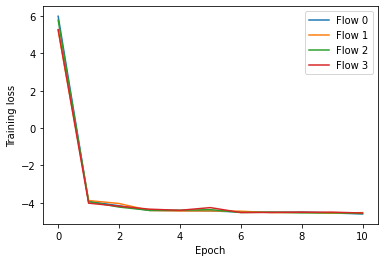

In [ ]:
for n, l in losses.items():
    plt.plot(l, label=n)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [ ]:
samples = flowEns.sample(10000, seed=0)

In [ ]:
samples

,redshift,u,g,r,i,z,y
0,1.196565,23.726080,23.800169,23.601974,23.401217,22.645859,22.552570
1,0.965425,22.652784,22.799084,22.686129,22.226753,21.818829,21.764687
2,1.422419,24.595898,24.925838,24.917219,24.686586,24.349642,24.044151
3,0.364769,24.964991,24.717510,23.885599,23.771875,23.631567,23.584503
4,0.496655,25.873547,25.600765,24.779123,24.385447,24.319740,24.342163
...,...,...,...,...,...,...,...
9995,0.252189,22.588293,21.823114,21.199287,21.013531,20.913452,20.867556
9996,0.823570,24.333296,24.267105,23.851736,23.014256,22.652197,22.609167
9997,1.578859,24.634840,24.603653,24.729992,24.596235,24.427792,24.180645
9998,0.363978,23.486118,23.115795,22.256012,22.105999,21.998407,21.926178


<Figure size 864x864 with 0 Axes>

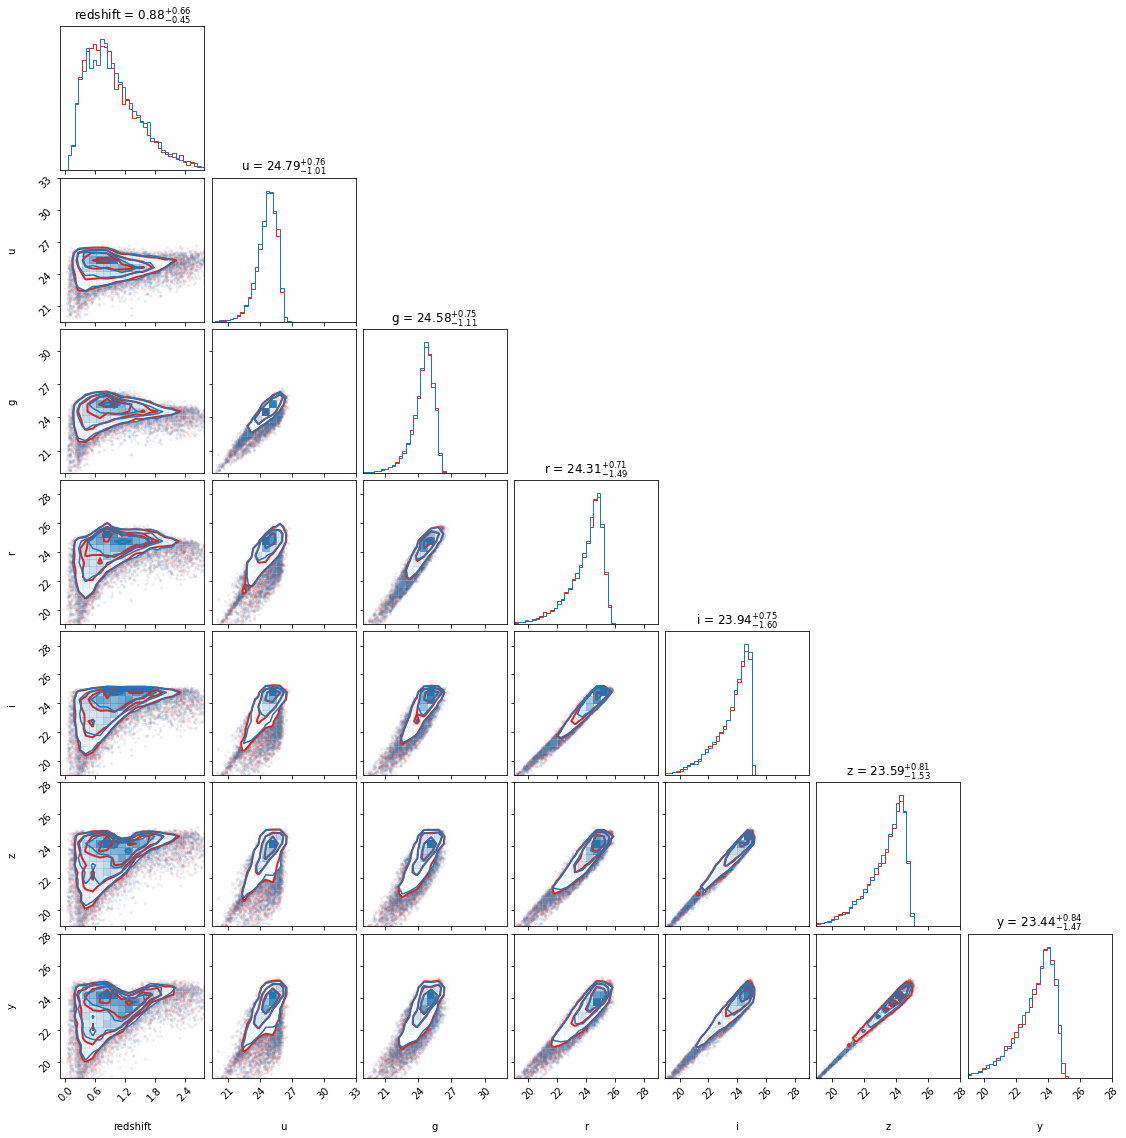

In [ ]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.8), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

fig = corner.corner(samples, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(trainingset.iloc[:10000, :7], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

In [ ]:
np.min(trainingset['redshift'].values), np.max(trainingset['redshift'].values)

(DeviceArray(0.01511955, dtype=float32), DeviceArray(3.2218933, dtype=float32))

We can also draw posteriors for magnitudes using the more general `posterior` method (in fact, `pz_estimate` is just a redshift wrapper of this method).

We can pass `column` and `grid` to calculate posteriors for different quanities.
For example, lets draw posteriors for the $u$ band:

In [ ]:
u_grid = np.arange(21, 30, 0.1)
sample_idx = np.arange(9, 12)
u_pdfs = dict()
u_pdfs = flowEns.posterior(trainingset.iloc[sample_idx], column='u', grid=u_grid)

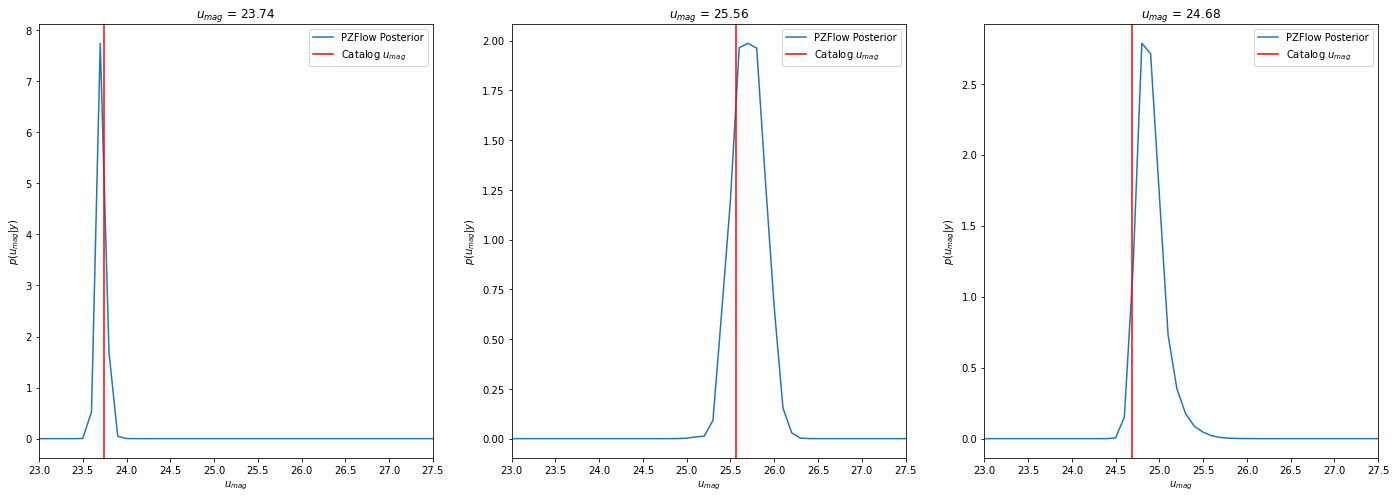

In [ ]:
fig = plt.figure(figsize=(24, 8))
for j, idx in list(enumerate(sample_idx)):
  fig.add_subplot(1,3,j+1)
  plt.plot(u_grid, pdf[j], label="PZFlow Posterior")
  plt.axvline(trainingset['u'].iloc[idx], 0, 1, c='r', label='Catalog $u_{mag}$')
  plt.title("$u_{mag}$ = " + f"{trainingset['u'].iloc[idx]:.2f}")
  plt.xlabel("$u_{mag}$")
  plt.ylabel("$p(u_{mag}|y)$")
  plt.legend()
  plt.xlim(23, 27.5)
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [ ]:
flowEns.info = f"""
This is an example flow ensemble, trained on 200,000 simulated galaxies with 
redshifts in the range (0, 3.2) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available to download at:
`https://epyc.astro.washington.edu/~brycek/train.cat`

This flow ensemble was created with pzflow version {pzflow.__version__}
"""

In [ ]:
print(flowEns.info)


This is an example flow ensemble, trained on 200,000 simulated galaxies with 
redshifts in the range (0, 3.2) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available to download at:
`https://epyc.astro.washington.edu/~brycek/train.cat`

This flow ensemble was created with pzflow version 2.0.0



Now let's save the flow ensemble to a file that can be loaded later:



In [ ]:
flowEns.save("/content/drive/MyDrive/DIRAC/pzflow/lsst-cat-flow-ensemble.pkl")

This file can be loaded on FlowEnsemble instantiation:

In [11]:
flowEns = FlowEnsemble(file="/content/drive/MyDrive/DIRAC/pzflow/lsst-cat-flow-ensemble.pkl")

## Estimate photo-z's with the flow

In this section we will run the trained flow saved in the section above on the test set to measure photo-z performance using `pzflow`.

First we set up a grid of redshifts for the PDF estimation. A finer grid will provide better resolution but also be slower.

In [12]:
test_batch_size = 2000
zmin = 0.
zmax = 3.5
dz = 0.01
z_grid = np.arange(zmin, zmax+(dz/2), dz)

Use this grid in the `posterior` function to generate the PDFs for redshift for each galaxy.

In [13]:
%%time 
testset_pdfs = flowEns.posterior(testset, 'redshift', z_grid, batch_size=2000, seed=42, returnEnsemble=True)

CPU times: user 1min 22s, sys: 22.8 s, total: 1min 45s
Wall time: 4min 41s


Here is a sample plot showing the output from each of the 4 flows in our ensemble.

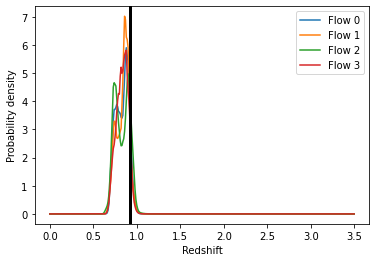

In [14]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

We can average across the ensemble PDFs to get a mean PDF estimate.

In [15]:
mean_test_pdfs = np.mean(testset_pdfs, axis=1)
np.shape(mean_test_pdfs)

(50000, 351)

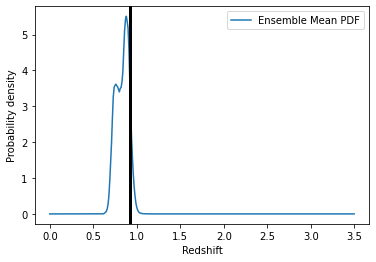

In [16]:
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

In [17]:
pmaxes = np.array([np.max(pz) for pz in mean_test_pdfs])
zmaxes = np.array([z_grid[pz.argmax()] for pz in mean_test_pdfs])

(0.0, 3.1)

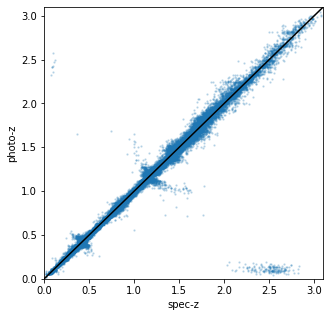

In [18]:
fig,ax = plt.subplots(figsize=(5,5))

plt.scatter(testset['redshift'], zmaxes, s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)

In [19]:
len(np.where(pmaxes < 10)[0])

13461

Text(0.5, 1.0, '"Quality cut" on pmax')

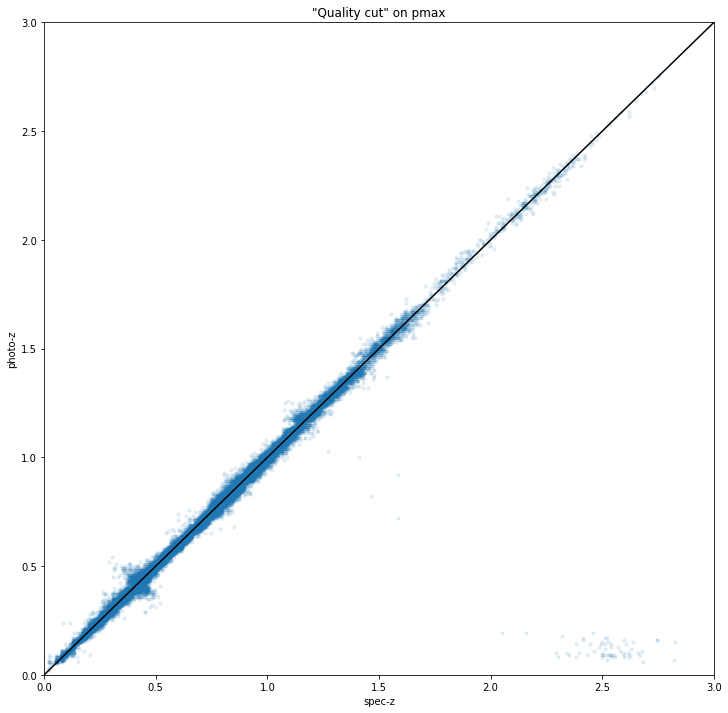

In [20]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(testset['redshift'].iloc[np.where(pmaxes > 10)], zmaxes[np.where(pmaxes > 10)], s=10, alpha=0.1)
plt.plot([0,3],[0,3], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.)
plt.ylim(0,3.)
plt.title('"Quality cut" on pmax')

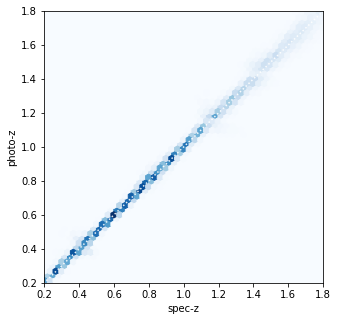

In [21]:
fig,ax = plt.subplots(figsize=(5,5))
plt.hexbin(testset['redshift'], zmaxes, cmap='Blues')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0.2,1.8)
plt.ylim(0.2,1.8)
plt.plot([0,3],[0,3], c='w', ls=':', alpha=0.9)

## CMNN Comparison


## Running PZ estimation using RAIL

In [33]:
! git clone https://github.com/LSSTDESC/RAIL.git
! git clone https://github.com/LSSTDESC/qp
! git clone https://github.com/LSSTDESC/DESC_BPZ.git

fatal: destination path 'RAIL' already exists and is not an empty directory.
fatal: destination path 'qp' already exists and is not an empty directory.
fatal: destination path 'DESC_BPZ' already exists and is not an empty directory.


In [34]:
! pip install flexcode

In [35]:
import sys
sys.path.insert(0, "/content/RAIL")
sys.path.insert(0, "/content/qp")
sys.path.insert(0, "/content/DESC_BPZ")

In [36]:
from tables_io import *
import qp

In [81]:
import rail

In [38]:
import yaml

In [82]:
nn_dict = {'run_params': {
  'class_name': 'simpleNN',
  'run_name': 'test_simpleNN',
  'zmin': 0.0,
  'zmax': 3.5,
  'nzbins': 301,
  'width': 0.05,
  'inform_options': {'save_train': True, 'load_model': False, 'modelfile': 'demo_NN_model.pkl'}
  }
}

### Prepare training and test data in hdf5 format for RAIL

In [40]:
from copy import copy
trainingset_hdf5 = copy(trainingset)

In [41]:
print(trainingset_hdf5.columns)

Index(['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err',
       'i_err', 'z_err', 'y_err'],
      dtype='object')


In [42]:
trainingset_hdf5.columns=['photometry/redshift', 'photometry/mag_u_lsst', 'photometry/mag_g_lsst', 
                          'photometry/mag_r_lsst', 'photometry/mag_i_lsst', 'photometry/mag_z_lsst', 
                          'photometry/mag_y_lsst', 'photometry/mag_err_u_lsst', 'photometry/mag_err_g_lsst', 
                          'photometry/mag_err_r_lsst', 'photometry/mag_err_i_lsst', 'photometry/mag_err_z_lsst',
                          'photometry/mag_err_y_lsst']

In [43]:
training_dict = trainingset_hdf5.to_dict(orient='list')

In [44]:
import numpy as onp
for key, val in training_dict.items():
  training_dict[key] = onp.array(training_dict[key])

In [50]:
import tables_io
tables_io.ioUtils.writeDictToHdf5(training_dict, 'train_cat.hdf5', None)

In [51]:
testset_hdf5 = copy(testset)

In [52]:
testset_hdf5.columns = trainingset_hdf5.columns

In [53]:
test_dict = testset_hdf5.to_dict(orient='list')

In [54]:
for key, val in test_dict.items():
  test_dict[key] = onp.array(test_dict[key])

In [55]:
tables_io.ioUtils.writeDictToHdf5(test_dict, 'test_cat.hdf5', None)

### Test RAIL photo-z estimation with simpleNN

In [77]:
with open('/content/RAIL/examples/estimation/example_estimation_base.yaml', 'r') as f:
  estimate_base_yaml = yaml.load(f, Loader=yaml.Loader)

In [78]:
estimate_base_yaml['base_config']['testfile'] = 'test_cat.hdf5'
estimate_base_yaml['base_config']['trainfile'] = 'train_cat.hdf5'

In [79]:
with open('/content/RAIL/examples/estimation/example_estimation_colab.yaml', 'w') as f:
  yaml.dump(estimate_base_yaml, f)

In [83]:
nn_dict

{'run_params': {'class_name': 'simpleNN',
  'inform_options': {'load_model': False,
   'modelfile': 'demo_NN_model.pkl',
   'save_train': True},
  'nzbins': 301,
  'run_name': 'test_simpleNN',
  'width': 0.05,
  'zmax': 3.5,
  'zmin': 0.0}}

In [84]:
pz = rail.estimation.algos.sklearn_nn.simpleNN('/content/RAIL/examples/estimation/example_estimation_colab.yaml',nn_dict)

summary of input parameters:
width: width (float): The ad hoc base width of the PDFs
width value: 0.05
zmin: zmin (float): The minimum redshift of the z grid
zmin value: 0.0
zmax: zmax (float): The maximum redshift of the z grid
zmax value: 3.5
nzbins: nzbins (int): The number of points in the z grid
nzbins value: 301
param max_iter not included in config, using default value
max_iter: max_iter (int): max number of iterations while training the neural net.  Too low a value will cause an error to be printed (though the code will still work, justnot optimally)
max_iter value: 500
param bands not included in config, using default value
bands: bands (str): bands to use in estimation
bands value: ugrizy
inform_options: inform_options (dict): a dictionary of options for loading and storing of the pretrained model.  This includes:
 modelfile (str): the filename to save or load a trained model to/from
 save_train (bool): boolean to set whether to save a trained model
 load_model (bool): boolea

In [85]:
trainfile = pz.trainfile
train_fmt = 'hdf5'
training_data = io.read(trainfile, None, train_fmt)[pz.groupname]

In [86]:
%%time
pz.inform(training_data)

stacking some data...
CPU times: user 4min 24s, sys: 2min 26s, total: 6min 50s
Wall time: 3min 41s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [87]:
test_data = io.read(pz.testfile, None, train_fmt)['photometry']

In [88]:
results_dict = pz.estimate(test_data)

In [89]:
test_data['redshift']

array([0.6481919 , 1.547445  , 0.98921716, ..., 0.5938748 , 1.51317   ,
       1.7474971 ])

In [90]:
import matplotlib as mpl
mpl.rcParams['text.usetex']=False

Text(0, 0.5, 'simple NN photo-z')

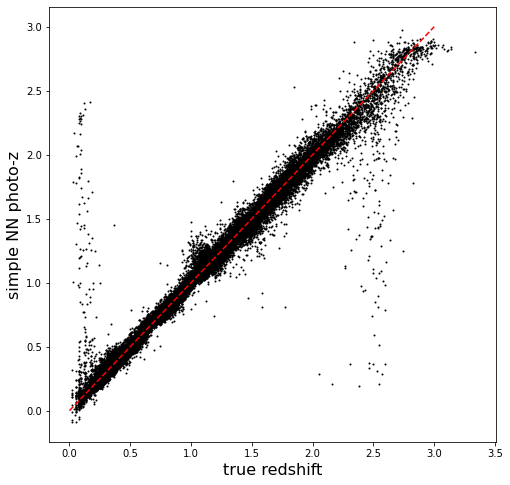

In [91]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],results_dict['zmode'],s=1,c='k',label='simple NN mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("simple NN photo-z")

Text(0, 0.5, 'p(z)')

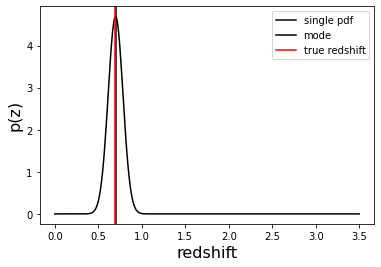

In [92]:
galid = 9529
zgrid = pz.zgrid
single_gal = results_dict['pz_pdf'][galid]
single_zmode = results_dict['zmode'][galid]
truez = test_data['redshift'][galid]
plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmode,color='k',label='mode')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")

### Calculating photo-z with flexZBoost and RAIL

In [152]:

fz_dict = {'run_params': {
  'class_name': 'FZBoost',
  'run_name': 'test_FZBoost',
  'zmin': 0.0,
  'zmax': 3.5,
  'nzbins': 351,
  'trainfrac': 0.75,
  'bumpmin': 0.02,
  'bumpmax': 0.35,
  'nbump': 20,
  'sharpmin': 0.7,
  'sharpmax': 2.1,
  'nsharp': 15,
  'max_basis': 35,
  'basis_system': 'cosine',
  'regression_params': {'max_depth': 8,'objective':'reg:squarederror'},
  'inform_options': {'save_train': True, 'load_model': False, 'modelfile': '/content/drive/MyDrive/DIRAC/pzflow/demo_FZB_model.pkl'}
  }
}

In [153]:
with open('/content/RAIL/examples/estimation/example_estimation_base_qp.yaml', 'r') as f:
  estimate_base_qp_yaml = yaml.load(f, Loader=yaml.Loader)

In [154]:
estimate_base_qp_yaml['base_config']['testfile'] = 'test_cat.hdf5'
estimate_base_qp_yaml['base_config']['trainfile'] = 'train_cat.hdf5'

In [155]:
with open('/content/RAIL/examples/estimation/example_estimation_colab_qp.yaml', 'w') as f:
  yaml.dump(estimate_base_qp_yaml, f)

In [156]:
pzflex = rail.estimation.algos.flexzboost.FZBoost('/content/RAIL/examples/estimation/example_estimation_colab.yaml',fz_dict)

summary of input parameters:
zmin: zmin (float): min value for z grid
zmin value: 0.0
zmax: zmax (float): max value for z grid
zmax value: 3.5
nzbins: nzbins (int): number of z bins
nzbins value: 351
trainfrac: trainfrac (float): fraction of training data to use for training (rest used for bump thresh and sharpening determination)
trainfrac value: 0.75
bumpmin: bumpmin (float): minimum value in grid of thresholds checked to optimize  removal of spurious small bumps
bumpmin value: 0.02
bumpmax: bumpmax (float) max value in grid checked for removal of small bumps
bumpmax value: 0.35
nbump: nbump (int): number of grid points in bumpthresh grid search
nbump value: 20
sharpmin: sharpmin (float): min value in grid checked for optimal sharpening parameter fit
sharpmin value: 0.7
sharpmax: sharpmax (float): max value in grid checked in optimal sharpening parameter fit
sharpmax value: 2.1
nsharp: nsharp (int): number of search points in sharpening fit
nsharp value: 15
max_basis: max_basis (int)

In [ ]:
%%time
pzflex.inform(training_data)

stacking some data...
read in training data
fit the model...


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


finding best bump thresh...


In [39]:
%%time
pzflex.load_pretrained_model()

success in loading /content/drive/MyDrive/DIRAC/pzflow/demo_FZB_model.pkl
CPU times: user 95.7 ms, sys: 168 ms, total: 263 ms
Wall time: 3.38 s


In [40]:
flex_results = pzflex.estimate(test_data)

In [41]:
fz_medians = flex_results['zmode']

In [42]:
flex_results['pz_pdf']

array([[ 3.75552676,  3.77009484,  3.81477308, ...,  0.        ,
         0.        ,  0.        ],
       [14.37698422, 14.22462576, 13.76523874, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.26892286,  9.33761654,  9.52297067, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 18.13043632,
        20.01289737, 20.66214132],
       [ 0.        ,  0.        ,  0.        , ...,  8.78078882,
         9.57088252,  9.84172648],
       [ 0.        ,  0.        ,  0.        , ..., 11.46990924,
        12.7843299 , 13.23813055]])

Text(0, 0.5, 'flex photo-z')

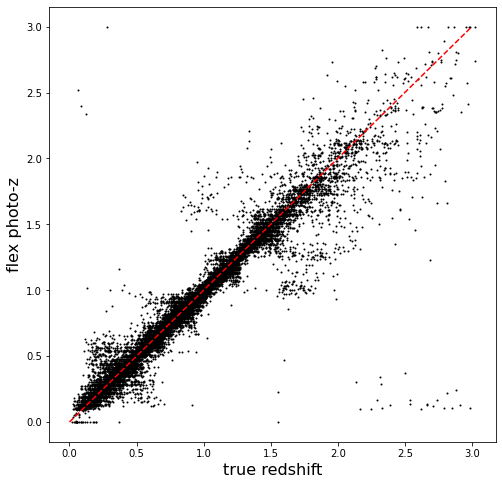

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],fz_medians,s=1,c='k',label='flexz medians')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("flex photo-z")

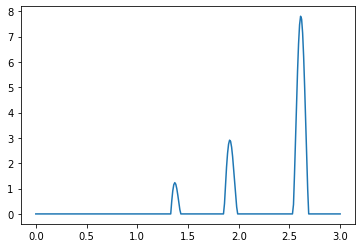

In [54]:
plt.plot(pzflex.zgrid, flex_results['pz_pdf'][-100])

### Calculating photo-z with BPZ and RAIL

In [93]:
with open('/content/RAIL/examples/estimation/configs/BPZ_lite.yaml', 'r') as f:
  bpz_params = yaml.load(f, Loader=yaml.Loader)

In [94]:
bpz_params['run_params']['columns_file'] = '/content/RAIL/examples/estimation/configs/test_bpz.columns'

In [95]:
bpz_params['run_params']['zmax'] = 3.5

In [96]:
pz_bpz = rail.estimation.algos.bpz_lite.BPZ_lite('/content/RAIL/examples/estimation/example_estimation_colab.yaml',bpz_params)

summary of input parameters:
zmin: zmin (float): min z  for grid
zmin value: 0.0
zmax: zmax (float): max z for grid
zmax value: 3.5
dz: dz (float): delta z in grid
dz value: 0.01
param nzbins not included in config, using default value
nzbins: nzbins (int): # of bins in zgrid
nzbins value: 301
param data_path not included in config, using default value
data_path: data_path (str): file path to the SED, FILTER, and AB directories.  If left to default `None` it will use the install directory for rail + estimation/data
data_path value: None
columns_file: columns_file (str): name of the file specifying the columns
columns_file value: /content/RAIL/examples/estimation/configs/test_bpz.columns
spectra_file: spectra_file (str): name of the file specifying the list of SEDs to use
spectra_file value: SED/CWWSB4.list
param madau_flag not included in config, using default value
madau_flag: madau_flag (str): set to 'yes' or 'no' to set whether to include intergalactic Madau reddening when construct

In [97]:
%%time
pz_bpz.inform(training_data)

CPU times: user 18 µs, sys: 8 µs, total: 26 µs
Wall time: 32.9 µs


In [98]:
%%time
bpz_results = pz_bpz.estimate(test_data)

CPU times: user 1min 6s, sys: 48.6 ms, total: 1min 6s
Wall time: 1min 6s


In [99]:
bpz_results['zmode']

array([0.69, 1.6 , 1.17, ..., 0.63, 1.22, 1.19])

Text(0, 0.5, 'bpz photo-z')

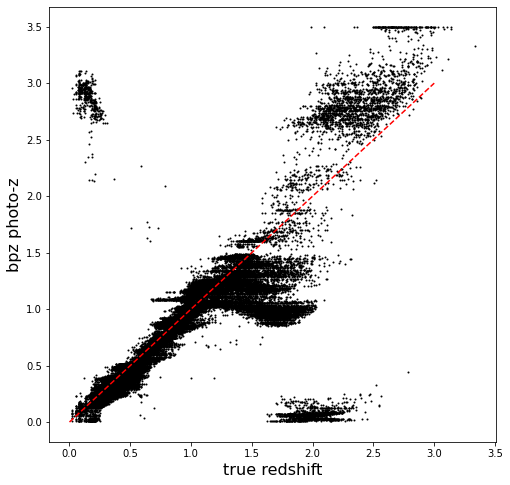

In [100]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],bpz_results['zmode'],s=1,c='k',label='bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

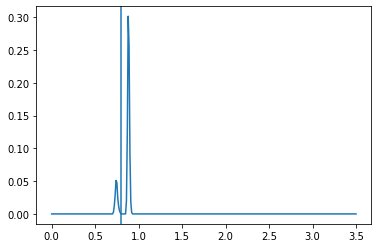

In [151]:
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][-100])
plt.axvline(testset['redshift'].iloc[-100])

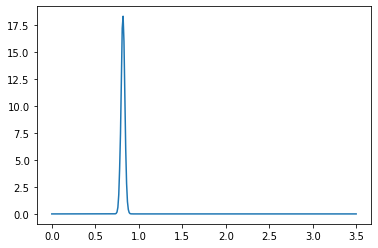

In [102]:
plt.plot(z_grid, mean_test_pdfs[-100])

In [103]:
test_data['redshift'][-100]

0.79452217

## Implement Brier Score predictions

In [104]:
from sklearn.metrics import brier_score_loss

In [105]:
from scipy.stats import norm
def test_z_pdf(z_est, z_err, dz, z_min, z_max):
    # Divide by 10 to get proper sampling with some very small uncertainties
    normed_val = norm.pdf(onp.arange(z_min, z_max+1e-6, dz/10), loc=z_est, scale=z_err)
    normed_sum = []
    for i in range(0, len(normed_val), 10):
        normed_sum.append(sum(normed_val[i:i+10])*(dz/10))
    if onp.sum(normed_sum) > 1.01:
        print(z_est, z_err)
    return normed_sum

In [106]:
z_min = 0
z_max = 3.5
dz = 0.01
z_arr = np.arange(z_min, z_max+1e-6, dz)

In [107]:
import numpy as onp

In [108]:
testset_bin_number = onp.digitize(testset['redshift'].values, z_arr)

In [109]:
testset_labels = onp.zeros((len(testset_bin_number), len(z_arr)))

In [110]:
for i, bin_num in list(enumerate(testset_bin_number)):
    testset_labels[i][bin_num] = 1

In [111]:
# https://stats.stackexchange.com/questions/403544/how-to-compute-the-brier-score-for-more-than-two-classes?rq=1

In [127]:
train_z_pdf, bin_edges = np.histogram(trainingset['redshift'].values, np.arange(0.00, 3.5101, 0.01))
train_z_pdf = np.array(train_z_pdf) / np.sum(train_z_pdf)

In [128]:
train_z_pdf = np.tile(train_z_pdf, len(testset_pdfs)).reshape(len(testset_pdfs), len(train_z_pdf))

In [129]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

In [139]:
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels, .01*onp.array(mean_test_pdfs)))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels, train_z_pdf))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels, bpz_results['pz_pdf']))
print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))

PZFlow Brier Score: 0.8492
Train_Z Brier Score: 0.9944
BPZ Brier Score: 1.1961
